In [74]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

### Load dữ liệu và xử lý

In [75]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1]).T
        X_test = X_test.reshape([X_test.shape[0], -1]).T
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_dataset(flatten=True)
def one_hot(y, n_class):
    return np.eye(n_class)[y]
y_train = one_hot(y_train, 10)

In [76]:
class Layer:
    def __init__(self) -> None:
        pass

    def forward(self, input):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((output_size, 1))
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.W.T, input) + self.b
        return self.output

    def backward(self, output_grad):
        input_grad = np.dot(self.W, output_grad)
        self.dW = np.dot(self.input, output_grad.T)
        self.db = np.sum(output_grad, axis=1, keepdims=True)
        return input_grad

    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.maximum(input, 0)
        return self.output

    def backward(self, output_grad):
        input_grad = output_grad.copy()
        input_grad[self.input <= 0] = 0
        return input_grad


class Softmax(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.exp(input) / np.sum(np.exp(input), axis=0)
        return self.output

    def backward(self, output_grad):
#         input_grad = self.output * (output_grad - np.sum(output_grad * self.output, axis=0, keepdims=True))
#         return input_grad
        return output_grad


class Model:
    def __init__(self) -> None:
        self.layers = []
        self.losses=[] 
        self.accuracies = []
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, output_grad):
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)

    def update(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Dense):
                layer.update(learning_rate)

    def fit(self, X, y, batch_size, epochs, learning_rate):
        n = X.shape[1]
        for epoch in range(epochs):
            for i in range(0, n, batch_size):
                X_batch = X[:, i:i+batch_size]
                y_batch = y.T[:, i:i+batch_size]
                y_pred = self.forward(X_batch)
                loss = self.loss(y_batch, y_pred)
               
                output_grad = self.loss_grad(y_batch, y_pred)
                self.backward(output_grad)
                self.update(learning_rate)
            accuracy = self.evaluate(X, np.argmax(y, axis=1))
            print('Epoch: {}, Loss: {}, Accuracy: {}'.format(epoch, loss, accuracy))
            self.losses.append(loss)
            self.accuracies.append(accuracy)

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=0)

    def loss(self, y, y_pred):
        return -np.sum(y * np.log(y_pred)) / y.shape[1]

    def loss_grad(self, y, y_pred):
        return (y_pred - y) / y.shape[1]
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def save_model(self, path):
        np.savez(path, *[layer.W for layer in self.layers if isinstance(layer, Dense)])
        
    def load_model(self, path):
        params = np.load(path)
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Dense):
                layer.W = params['arr_{}'.format(i)]
                layer.b = np.zeros((layer.W.shape[1], 1))
                
    def history(self):
        return self.losses, self.accuracies
    

In [77]:
model = Model()
model.add(Dense(784, 128))
model.add(ReLU())
model.add(Dense(128, 10))
model.add(Softmax())
model.fit(X_train, y_train,64, 10, 0.1)

Epoch: 0, Loss: 0.11681020424767687, Accuracy: 0.9121666666666667
Epoch: 1, Loss: 0.05999004328235199, Accuracy: 0.9370833333333334
Epoch: 2, Loss: 0.040422806858220875, Accuracy: 0.9513333333333334
Epoch: 3, Loss: 0.03448782357478926, Accuracy: 0.9602666666666667
Epoch: 4, Loss: 0.03122052332828189, Accuracy: 0.9668166666666667
Epoch: 5, Loss: 0.02903592066823782, Accuracy: 0.9709
Epoch: 6, Loss: 0.02716210025929476, Accuracy: 0.9742166666666666
Epoch: 7, Loss: 0.025301329901542692, Accuracy: 0.9769
Epoch: 8, Loss: 0.02415247593058048, Accuracy: 0.97915
Epoch: 9, Loss: 0.022496977835859272, Accuracy: 0.9811666666666666


In [78]:
np.sum(model.predict(X_test)==y_test)

9718

In [79]:
(loss,acc) = model.history()

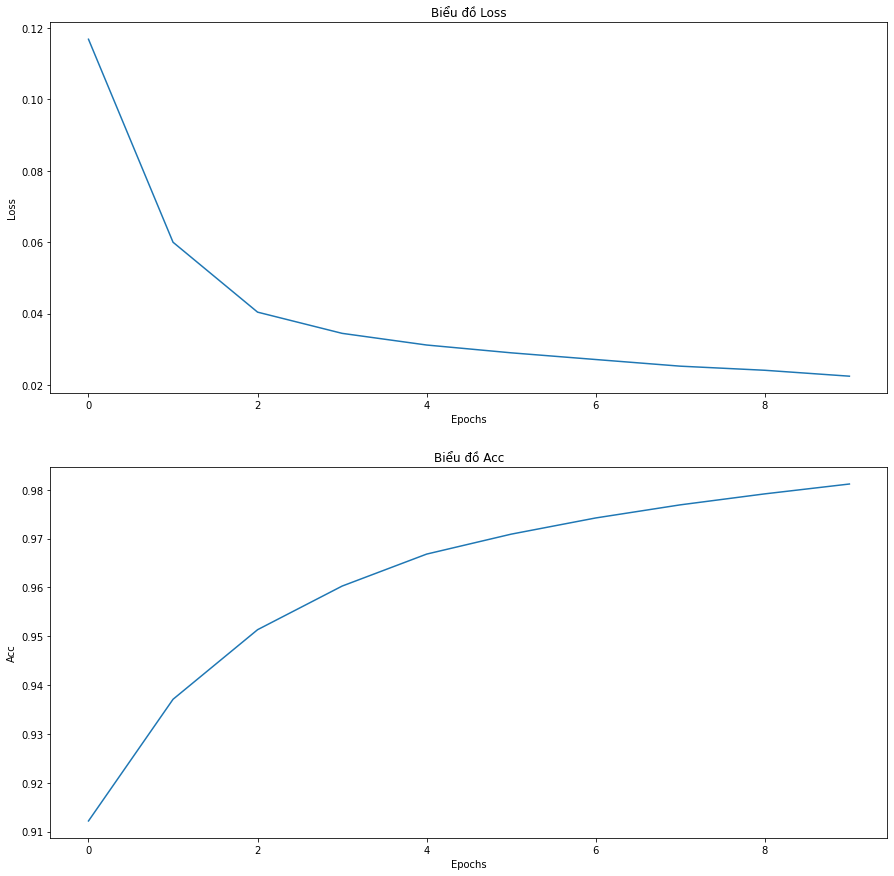

In [80]:
plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
plt.plot(loss)
plt.title("Biểu đồ Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2,1,2)
plt.plot(acc)
plt.title("Biểu đồ Acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

### Visualize data

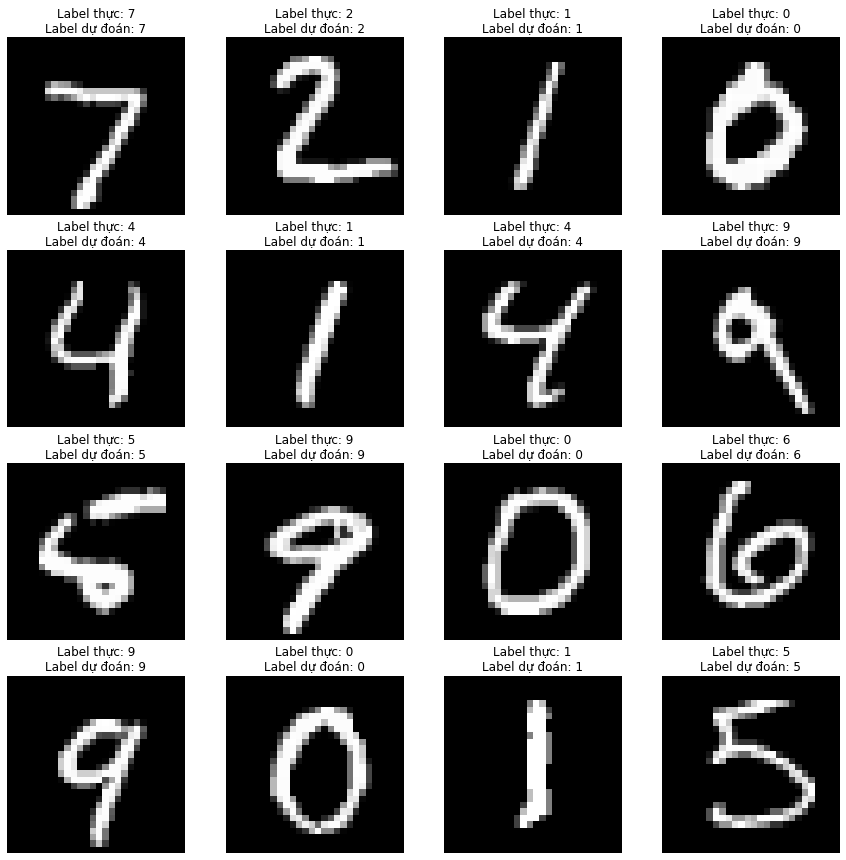

In [81]:
y_pre = model.predict(X_test)
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(f"Label thực: {y_test[i]}\nLabel dự đoán: {y_pre[i]}")
    plt.imshow(X_test[:, i].reshape([28, 28]), cmap='gray')
    plt.axis('off')